<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np # Ensure numpy is imported early for later use
import pandas as pd # Ensure pandas is imported early for later use

print("\n[Drive Setup] Google Drive 마운트 중...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("   ✓ Google Drive 마운트 성공!")
    drive_mounted = True
    # 저장할 기본 경로 설정 (내 드라이브의 'cha poster' 폴더)
    base_save_path = "/content/drive/MyDrive/cha poster" # Your Google Drive folder path
except ImportError:
    print("   ⚠️ Google Colab 환경이 아닙니다. 현재 디렉토리에 저장합니다.")
    drive_mounted = False
    base_save_path = "." # Save in the current directory if not on Colab

print(f"\n[Drive Setup] 저장 폴더 확인 및 생성: {base_save_path}")
if drive_mounted:
    if not os.path.exists(base_save_path):
        os.makedirs(base_save_path)
        print(f"   ✓ 폴더 '{base_save_path}' 생성 완료!")
    else:
        print(f"   ✓ 폴더 '{base_save_path}'가 이미 존재합니다.")
elif not os.path.exists(base_save_path) and base_save_path != ".":
    try:
        os.makedirs(base_save_path)
        print(f"   ✓ 폴더 '{base_save_path}' 생성 완료!")
    except OSError as e:
        print(f"   ❌ 폴더 생성 실패 (현재 디렉토리에 저장합니다): {e}")
        base_save_path = "."
else:
     print(f"   ✓ 현재 디렉토리('.')에 저장합니다.")
print("="*60)



[Drive Setup] Google Drive 마운트 중...
Mounted at /content/drive
   ✓ Google Drive 마운트 성공!

[Drive Setup] 저장 폴더 확인 및 생성: /content/drive/MyDrive/cha poster
   ✓ 폴더 '/content/drive/MyDrive/cha poster'가 이미 존재합니다.


In [ ]:
# SHAP 최신 버전으로 업그레이드
!pip install shap --upgrade

# 라이브러리 다시 임포트
import shap
import numpy as np

print(f"✓ NumPy: {np.__version__}")
print(f"✓ SHAP: {shap.__version__}")
print("✓ 수정 완료! 이제 다음 셀부터 실행하세요!")

✓ NumPy: 2.0.2
✓ SHAP: 0.49.1
✓ 수정 완료! 이제 다음 셀부터 실행하세요!


In [ ]:
# 구글 코랩에서 실행
!pip install GEOparse pandas numpy scikit-learn imbalanced-learn matplotlib seaborn shap

# 라이브러리 임포트
import GEOparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import random
import os

# 재현성을 위한 Seed 설정
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy random seed
np.random.seed(SEED)

# 환경 변수 설정
os.environ['PYTHONHASHSEED'] = str(SEED)

print("\n" + "="*60)
print("✓ 라이브러리 로드 완료!")
print("✓ Random Seed 설정: 42 (재현 가능한 실험)")
print("="*60 + "\n")


✓ 라이브러리 로드 완료!
✓ Random Seed 설정: 42 (재현 가능한 실험)



In [ ]:
# GEO 데이터셋 다운로드
gse = GEOparse.get_GEO(geo="GSE39833", destdir="./data/")

# 샘플 메타데이터 확인
print(f"총 샘플 수: {len(gse.gsms)}")

# 발현 데이터 추출
expression_data = []
sample_labels = []

for gsm_name, gsm in gse.gsms.items():
    # 발현 데이터 추출
    expr_values = gsm.table['VALUE'].values
    expression_data.append(expr_values)

    # 라벨 추출 (HC: 건강한 대조군=0, CRC: 대장암 환자=1)
    title = gsm.metadata['title'][0]
    if 'HC' in title:
        sample_labels.append(0)
    else:
        sample_labels.append(1)

# DataFrame 생성
# miRNA 이름 추출 (첫 번째 샘플 기준)
first_sample = list(gse.gsms.values())[0]
mirna_names = first_sample.table['ID_REF'].values

print("\n[디버깅] mirna_names 샘플 (처음 5개):")
print(mirna_names[:5])
print(f"데이터 타입: {type(mirna_names[0])}")

df_expression = pd.DataFrame(expression_data, columns=mirna_names)
df_expression['label'] = sample_labels

print(f"데이터 shape: {df_expression.shape}")
print(f"건강한 대조군: {sum(df_expression['label']==0)}명")
print(f"대장암 환자: {sum(df_expression['label']==1)}명")

# GPL14767 플랫폼에서 매핑 정보 추출
try:
    platform = gse.gpls['GPL14767']
    df_platform = platform.table

    # [디버깅] 플랫폼 정보 확인
    print("\n[디버깅] 플랫폼 컬럼:")
    print(df_platform.columns.tolist())
    print("\n[디버깅] 플랫폼 테이블 샘플 (ID 3~8, 실제 miRNA 영역):")
    print(df_platform.iloc[2:8][['ID', 'PROBE NAME', 'miRNA_ID', 'SPOT_ID']])

    # ID와 mirna_names를 모두 문자열로 통일
    df_platform['ID'] = df_platform['ID'].astype(str)
    mirna_names_str = [str(x) for x in mirna_names]

    # ✅ 수정: SPOT_ID 대신 miRNA_ID 사용!
    mirna_mapping = dict(zip(df_platform['ID'], df_platform['miRNA_ID']))

    # NaN 값 개수 확인
    nan_count = sum(pd.isna(v) for v in mirna_mapping.values())
    print(f"\n✓ miRNA 매핑 테이블 생성: {len(mirna_mapping)}개")
    print(f"  - 실제 miRNA: {len(mirna_mapping) - nan_count}개")
    print(f"  - 컨트롤/매핑 안됨: {nan_count}개")

    # 테스트: 실제 miRNA 데이터 영역(ID 3~)에서 확인
    test_ids = mirna_names_str[2:7]  # ID 3~7 (컨트롤 제외)
    print(f"\n📌 매핑 확인 (실제 miRNA 데이터, ID 3~7):")
    for test_id in test_ids:
        mapped_name = mirna_mapping.get(test_id, 'NOT FOUND')
        # NaN도 명확히 표시
        if pd.isna(mapped_name):
            mapped_name = 'NaN (매핑 안됨)'
        print(f"   ID {test_id} → {mapped_name}")

except Exception as e:
    print(f"⚠️ 매핑 테이블 생성 실패: {e}")
    import traceback
    traceback.print_exc()
    mirna_mapping = {}
# ============================================================
# ✅ DataFrame 컬럼명을 miRNA 이름으로 변경
# ============================================================
print("\n" + "="*60)
print("DataFrame 컬럼명을 miRNA 이름으로 변경")
print("="*60)

# 1. 현재 컬럼명(숫자)을 문자열로 변환
current_columns = [str(col) for col in df_expression.columns if col != 'label']

# 2. 매핑 적용: ID → miRNA 이름
# 매핑이 없으면 원래 ID 유지, NaN이면 "Unknown_ID_{숫자}" 형태로 표시
new_columns = []
unmapped_count = 0
control_count = 0

for col in current_columns:
    if col in mirna_mapping:
        mapped_name = mirna_mapping[col]

        # NaN 체크
        if pd.isna(mapped_name):
            # NaN인 경우: 컨트롤 프로브이거나 매핑 안된 프로브
            new_columns.append(f"Unknown_ID_{col}")
            unmapped_count += 1
        else:
            # 정상적으로 매핑된 경우
            new_columns.append(mapped_name)
    else:
        # 딕셔너리에 아예 없는 경우 (드물지만 대비)
        new_columns.append(f"Unknown_ID_{col}")
        unmapped_count += 1

# 3. label 컬럼도 포함
new_columns.append('label')

# 4. 컬럼명 변경
df_expression.columns = new_columns

print(f"✓ 컬럼명 변경 완료!")
print(f"  - 전체 특징: {len(current_columns)}개")
print(f"  - 매핑 성공: {len(current_columns) - unmapped_count}개")
print(f"  - 매핑 실패/컨트롤: {unmapped_count}개")

# 5. 변경 후 확인
print(f"\n📌 변경된 컬럼명 샘플 (처음 10개):")
print(df_expression.columns[:10].tolist())

# 6. 중복 체크 (같은 miRNA가 여러 프로브로 측정되는 경우)
duplicate_check = df_expression.columns[df_expression.columns.duplicated()].tolist()
if duplicate_check and 'label' not in duplicate_check:
    print(f"\n⚠️ 경고: 중복된 miRNA 이름 발견 ({len(duplicate_check)}개)")
    print(f"  예시: {duplicate_check[:5]}")
    print("  → 같은 miRNA를 다른 프로브로 측정한 경우입니다.")
else:
    print(f"\n✓ 중복 없음: 모든 컬럼명이 고유합니다.")

print("="*60 + "\n")

28-Oct-2025 14:52:47 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz
100%|██████████| 11.4M/11.4M [00:00<00:00, 24.4MB/s]
28-Oct-2025 14:52:47 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
28-Oct-2025 14:52:47 DEBUG downloader - Moving /tmp/tmp7heoaem7 to /content/data/GSE39833_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp7heoaem7 to /content/data/GSE39833_family.soft.gz
28-Oct-2025 14:52:47 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
28-Oct-2025 14:52:47 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz

총 샘플 수: 99

[디버깅] mirna_names 샘플 (처음 5개):
[1 2 3 4 5]
데이터 타입: <class 'numpy.int64'>
데이터 shape: (99, 15740)
건강한 대조군: 11명
대장암 환자: 88명

[디버깅] 플랫폼 컬럼:
['ID', 'PROBE NAME', 'CONTROL_TYPE', 'miRNA_ID', 'GENE_NAME', 'ACCESSION_STRING', 'CHROMOSOMAL_LOCATION', 'SPOT_ID']

[디버깅] 플랫폼 테이블 샘플 (ID 3~8, 실제 miRNA 영역):
   ID      PROBE NAME        miRNA_ID SPOT_ID
2   3  A_25_P00015264     hsa-miR-720     NaN
3   4  A_25_P00011633     hsa-miR-587     NaN
4   5  A_25_P00014956    hsa-miR-1236     NaN
5   6  A_25_P00011449     hsa-miR-607     NaN
6   7  A_25_P00015155    hsa-miR-1253     NaN
7   8  A_25_P00013991  hsa-miR-369-3p     NaN

✓ miRNA 매핑 테이블 생성: 15744개
  - 실제 miRNA: 15024개
  - 컨트롤/매핑 안됨: 720개

📌 매핑 확인 (실제 miRNA 데이터, ID 3~7):
   ID 3 → hsa-miR-720
   ID 4 → hsa-miR-587
   ID 5 → hsa-miR-1236
   ID 6 → hsa-miR-607
   ID 7 → hsa-miR-1253

DataFrame 컬럼명을 miRNA 이름으로 변경
✓ 컬럼명 변경 완료!
  - 전체 특징: 15739개
  - 매핑 성공: 15024개
  - 매핑 실패/컨트롤: 715개

📌 변경된 컬럼명 샘플 (처음 10개):
['Unknown_ID_1', 'Unknown_ID_2', 'hsa

In [ ]:
X = df_expression.drop('label', axis=1)
y = df_expression['label']

from imblearn.pipeline import Pipeline  # sklearn.pipeline이 아닌 imblearn.pipeline 사용!
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
import numpy as np
import pandas as pd

print("="*60)
print("올바른 방법: Pipeline + Nested Cross-Validation")
print("="*60)

# 5-Fold Stratified CV 설정
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 1. Random Forest 파이프라인 (모든 전처리가 파이프라인 내부에!)
rf_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.01)),  # 저분산 제거
    ('feature_selection', SelectKBest(f_classif, k=30)),     # 특징 선택
    ('smote', SMOTE(random_state=42, k_neighbors=3)),        # SMOTE
    ('scaler', StandardScaler()),                             # 표준화
    ('classifier', RandomForestClassifier(random_state=42))   # 분류기
])

# 하이퍼파라미터 그리드 (inner CV에서 튜닝)
rf_param_grid = {
    'feature_selection__k': [40],
    'smote__k_neighbors': [2],
    'classifier__n_estimators': [100],
    'classifier__max_depth': [4,5],
    'classifier__min_samples_split': [5,10],
    'classifier__min_samples_leaf': [2,4]
}

# GridSearchCV로 inner CV 설정
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=inner_cv,           # Inner CV: 하이퍼파라미터 튜닝
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Outer CV로 최종 성능 평가
print("\n[Random Forest - Nested Cross-Validation]")
rf_outer_scores = cross_validate(
    rf_grid,
    X, y,
    cv=outer_cv,          # Outer CV: 일반화 성능 평가
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# 결과 출력
print("\n결과 (5-Fold Outer CV):")
print(f"ROC-AUC: {rf_outer_scores['test_roc_auc'].mean():.4f} ± {rf_outer_scores['test_roc_auc'].std():.4f}")
print(f"정확도: {rf_outer_scores['test_accuracy'].mean():.4f} ± {rf_outer_scores['test_accuracy'].std():.4f}")
print(f"정밀도: {rf_outer_scores['test_precision'].mean():.4f} ± {rf_outer_scores['test_precision'].std():.4f}")
print(f"재현율: {rf_outer_scores['test_recall'].mean():.4f} ± {rf_outer_scores['test_recall'].std():.4f}")
print(f"F1 점수: {rf_outer_scores['test_f1'].mean():.4f} ± {rf_outer_scores['test_f1'].std():.4f}")


# 2. SVM 파이프라인
print("\n" + "="*60)
print("[SVM - Nested Cross-Validation]")
print("="*60)

svm_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.01)),
    ('feature_selection', SelectKBest(f_classif, k=30)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'feature_selection__k': [40],
    'classifier__C': [0.1, 1.0, 10.0],  # 정규화 강도
    'classifier__gamma': ['scale', 0.01],
    'classifier__kernel': ['rbf', 'linear', 'poly']
}

svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=inner_cv,
                        scoring='roc_auc', n_jobs=-1, verbose=1)

svm_outer_scores = cross_validate(
    svm_grid, X, y, cv=outer_cv,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
    return_train_score=True, n_jobs=-1, verbose=1
)

print("\n결과 (5-Fold Outer CV):")
print(f"ROC-AUC: {svm_outer_scores['test_roc_auc'].mean():.4f} ± {svm_outer_scores['test_roc_auc'].std():.4f}")
print(f"정확도: {svm_outer_scores['test_accuracy'].mean():.4f} ± {svm_outer_scores['test_accuracy'].std():.4f}")


# 3. Logistic Regression 파이프라인
print("\n" + "="*60)
print("[Logistic Regression - Nested Cross-Validation]")
print("="*60)

lr_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.01)),
    ('feature_selection', SelectKBest(f_classif, k=30)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_param_grid = {
    'feature_selection__k': [40],
    'classifier__C': [0.01, 0.1, 1.0],  # 강한 정규화
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga']
}

lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=inner_cv,
                       scoring='roc_auc', n_jobs=-1, verbose=1)

lr_outer_scores = cross_validate(
    lr_grid, X, y, cv=outer_cv,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
    return_train_score=True, n_jobs=-1, verbose=1
)

print("\n결과 (5-Fold Outer CV):")
print(f"ROC-AUC: {lr_outer_scores['test_roc_auc'].mean():.4f} ± {lr_outer_scores['test_roc_auc'].std():.4f}")
print(f"정확도: {lr_outer_scores['test_accuracy'].mean():.4f} ± {lr_outer_scores['test_accuracy'].std():.4f}")


# 4. 최종 모델 선택 및 전체 데이터로 재훈련
print("\n" + "="*60)
print("최종 모델 훈련 (전체 데이터)")
print("="*60)

# 가장 성능이 좋은 모델 선택 (예: Random Forest)
best_model = rf_grid  # 또는 svm_grid, lr_grid

# 전체 데이터로 최종 모델 훈련 (내부적으로 inner CV로 최적 파라미터 찾음)
best_model.fit(X, y)

print(f"\n최적 하이퍼파라미터: {best_model.best_params_}")
print(f"Inner CV 최고 점수 (ROC-AUC): {best_model.best_score_:.4f}")

# 최종 모델 저장
final_model = best_model.best_estimator_


올바른 방법: Pipeline + Nested Cross-Validation

[Random Forest - Nested Cross-Validation]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



결과 (5-Fold Outer CV):
ROC-AUC: 0.9608 ± 0.0515
정확도: 0.9395 ± 0.0373
정밀도: 0.9573 ± 0.0396
재현율: 0.9771 ± 0.0280
F1 점수: 0.9663 ± 0.0207

[SVM - Nested Cross-Validation]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



결과 (5-Fold Outer CV):
ROC-AUC: 0.8925 ± 0.0933
정확도: 0.9079 ± 0.0623

[Logistic Regression - Nested Cross-Validation]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished



결과 (5-Fold Outer CV):
ROC-AUC: 0.9497 ± 0.0732
정확도: 0.8979 ± 0.0586

최종 모델 훈련 (전체 데이터)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

최적 하이퍼파라미터: {'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'feature_selection__k': 40, 'smote__k_neighbors': 2}
Inner CV 최고 점수 (ROC-AUC): 0.8411


과적합 확인

In [ ]:
# ===== Train-Test Gap 즉시 확인 =====
print("="*60)
print("Random Forest - Train vs Test 비교 (과적합 진단)")
print("="*60)

# ROC-AUC
train_auc = rf_outer_scores['train_roc_auc'].mean()
test_auc = rf_outer_scores['test_roc_auc'].mean()
gap_auc = train_auc - test_auc

print(f"\nROC-AUC:")
print(f"  Train: {train_auc:.4f} ± {rf_outer_scores['train_roc_auc'].std():.4f}")
print(f"  Test:  {test_auc:.4f} ± {rf_outer_scores['test_roc_auc'].std():.4f}")
print(f"  Gap:   {gap_auc:.4f}")

# 정확도
train_acc = rf_outer_scores['train_accuracy'].mean()
test_acc = rf_outer_scores['test_accuracy'].mean()
gap_acc = train_acc - test_acc

print(f"\n정확도:")
print(f"  Train: {train_acc:.4f} ± {rf_outer_scores['train_accuracy'].std():.4f}")
print(f"  Test:  {test_acc:.4f} ± {rf_outer_scores['test_accuracy'].std():.4f}")
print(f"  Gap:   {gap_acc:.4f}")

# 과적합 판단
print(f"\n{'='*60}")
print("과적합 진단:")
print(f"{'='*60}")

if gap_auc < 0.02:
    print("✅ ROC-AUC Gap < 0.02 → 과적합 거의 없음!")
elif gap_auc < 0.05:
    print("△ ROC-AUC Gap 0.02~0.05 → 경미한 과적합 (허용 가능)")
elif gap_auc < 0.10:
    print("⚠️ ROC-AUC Gap 0.05~0.10 → 중간 과적합 (주의 필요)")
else:
    print("❌ ROC-AUC Gap > 0.10 → 심각한 과적합!")

print(f"{'='*60}")

Random Forest - Train vs Test 비교 (과적합 진단)

ROC-AUC:
  Train: 0.9997 ± 0.0006
  Test:  0.9608 ± 0.0515
  Gap:   0.0389

정확도:
  Train: 0.9925 ± 0.0100
  Test:  0.9395 ± 0.0373
  Gap:   0.0530

과적합 진단:
△ ROC-AUC Gap 0.02~0.05 → 경미한 과적합 (허용 가능)


모델성능 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve
import numpy as np

print("="*60)
print("6단계: 최종 모델 상세 평가")
print("="*60)

# 최종 모델 재확인
print(f"\n최종 선택 모델: Random Forest")
print(f"최적 하이퍼파라미터: {best_model.best_params_}")
print(f"교차검증 ROC-AUC: 0.8977 ± 0.0837")

# 전체 데이터로 예측 (교차검증 방식)
from sklearn.model_selection import cross_val_predict

# 각 샘플에 대한 예측 확률 (CV 방식)
y_pred_proba = cross_val_predict(
    best_model.best_estimator_,
    X, y,
    cv=outer_cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# 각 샘플에 대한 예측 클래스
y_pred = cross_val_predict(
    best_model.best_estimator_,
    X, y,
    cv=outer_cv,
    n_jobs=-1
)

print(f"\n전체 데이터 기반 성능:")
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print(f"정확도: {accuracy_score(y, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y, y_pred_proba):.4f}")
print(f"\n상세 분류 리포트:")
print(classification_report(y, y_pred, target_names=['Healthy', 'CRC'], digits=4))


6단계: 최종 모델 상세 평가

최종 선택 모델: Random Forest
최적 하이퍼파라미터: {'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'feature_selection__k': 40, 'smote__k_neighbors': 2}
교차검증 ROC-AUC: 0.8977 ± 0.0837

전체 데이터 기반 성능:
정확도: 0.9394
ROC-AUC: 0.9556

상세 분류 리포트:
              precision    recall  f1-score   support

     Healthy     0.7778    0.6364    0.7000        11
         CRC     0.9556    0.9773    0.9663        88

    accuracy                         0.9394        99
   macro avg     0.8667    0.8068    0.8331        99
weighted avg     0.9358    0.9394    0.9367        99



In [ ]:
# ============================================================
# 6.5단계: final_results 딕셔너리 생성
# ============================================================
print("\n" + "="*60)
print("6.5단계: 연구 결과 정리")
print("="*60)

import numpy as np

# CSV 파일에서 바이오마커 정보 읽기
try:
    feature_importance_df = pd.read_csv(os.path.join(base_save_path, 'feature_importance_all_mirnas.csv'))
    top_mirnas = feature_importance_df['miRNA'].head(10).tolist()
    top_importances = feature_importance_df['Importance'].head(10).tolist()
except:
    print("⚠️ feature_importance_all_mirnas.csv 파일을 찾을 수 없습니다.")
    top_mirnas = []
    top_importances = []

# SHAP 바이오마커 정보
try:
    shap_importance_df = pd.read_csv(os.path.join(base_save_path, 'shap_importance_all_mirnas.csv'))
    top_shap_mirnas = shap_importance_df['miRNA'].head(10).tolist()
    top_shap_values = shap_importance_df['SHAP_Importance'].head(10).tolist()
except:
    print("⚠️ shap_importance_all_mirnas.csv 파일을 찾을 수 없습니다.")
    top_shap_mirnas = []
    top_shap_values = []

# final_results 딕셔너리 생성
final_results = {
    "Research_Title": "Exosomal miRNA-based Colorectal Cancer Classification using Machine Learning",
    "Dataset": {
        "Source": "GEO GSE39833",
        "Total_Samples": len(df_expression),
        "Healthy_Controls": int(sum(df_expression['label'] == 0)),
        "CRC_Patients": int(sum(df_expression['label'] == 1)),
        "Original_Features": df_expression.shape[1] - 1,  # label 제외
        "Selected_Features": X.shape[1]  # 전처리 후 특징 수
    },
    "Best_Model": {
        "Algorithm": "Random Forest",
        "Hyperparameters": best_model.best_params_ if 'best_model' in locals() else "N/A",
        "Cross_Validation": "5-Fold Stratified Nested CV"
    },
    "Performance_Metrics": {
        "ROC_AUC": {
            "Mean": float(rf_outer_scores['test_roc_auc'].mean()),
            "Std": float(rf_outer_scores['test_roc_auc'].std()),
            "CI_95_Lower": float(rf_outer_scores['test_roc_auc'].mean() - 1.96 * rf_outer_scores['test_roc_auc'].std()),
            "CI_95_Upper": float(rf_outer_scores['test_roc_auc'].mean() + 1.96 * rf_outer_scores['test_roc_auc'].std())
        },
        "Accuracy": {
            "Mean": float(rf_outer_scores['test_accuracy'].mean()),
            "Std": float(rf_outer_scores['test_accuracy'].std())
        },
        "Precision": {
            "Mean": float(rf_outer_scores['test_precision'].mean()),
            "Std": float(rf_outer_scores['test_precision'].std())
        },
        "Recall": {
            "Mean": float(rf_outer_scores['test_recall'].mean()),
            "Std": float(rf_outer_scores['test_recall'].std())
        },
        "F1_Score": {
            "Mean": float(rf_outer_scores['test_f1'].mean()),
            "Std": float(rf_outer_scores['test_f1'].std())
        }
    },
    "Model_Comparison": {
        "Random_Forest": {
            "ROC_AUC": f"{rf_outer_scores['test_roc_auc'].mean():.4f} ± {rf_outer_scores['test_roc_auc'].std():.4f}",
            "Accuracy": f"{rf_outer_scores['test_accuracy'].mean():.4f} ± {rf_outer_scores['test_accuracy'].std():.4f}"
        },
        "SVM": {
            "ROC_AUC": f"{svm_outer_scores['test_roc_auc'].mean():.4f} ± {svm_outer_scores['test_roc_auc'].std():.4f}",
            "Accuracy": f"{svm_outer_scores['test_accuracy'].mean():.4f} ± {svm_outer_scores['test_accuracy'].std():.4f}"
        } if 'svm_outer_scores' in locals() else "Not trained",
        "Logistic_Regression": {
            "ROC_AUC": f"{lr_outer_scores['test_roc_auc'].mean():.4f} ± {lr_outer_scores['test_roc_auc'].std():.4f}",
            "Accuracy": f"{lr_outer_scores['test_accuracy'].mean():.4f} ± {lr_outer_scores['test_accuracy'].std():.4f}"
        } if 'lr_outer_scores' in locals() else "Not trained"
    },
    "Top_10_Biomarker_miRNAs": top_mirnas,
    "Top_10_Feature_Importance_Values": top_importances,
    "Top_10_SHAP_miRNAs": top_shap_mirnas,
    "Top_10_SHAP_Values": top_shap_values,
    "Generated_Figures": [
        "confusion_matrix_final.png",
        "roc_curve_final.png",
        "model_comparison.png",
        "learning_curves.png",
        "cv_score_distribution.png",
        "feature_importance_top20.png",
        "shap_summary_plot_bar.png",
        "shap_summary_plot_dot.png",
        "shap_waterfall_plot.png",
        "shap_importance_top20.png"
    ],
    "Data_Files": [
        "feature_importance_all_mirnas.csv",
        "shap_importance_all_mirnas.csv",
        "final_research_results.json",
        "research_summary_for_poster.txt"
    ]
}

# 결과 출력
print("\n✅ final_results 딕셔너리 생성 완료!")
print("\n📊 연구 결과 요약:")
print(f"   • 데이터셋: {final_results['Dataset']['Total_Samples']}명")
print(f"   • 건강인: {final_results['Dataset']['Healthy_Controls']}명")
print(f"   • CRC 환자: {final_results['Dataset']['CRC_Patients']}명")
print(f"   • 원본 특징: {final_results['Dataset']['Original_Features']}개")
print(f"   • 선택된 특징: {final_results['Dataset']['Selected_Features']}개")
print(f"\n   • ROC-AUC: {final_results['Performance_Metrics']['ROC_AUC']['Mean']:.4f} ± {final_results['Performance_Metrics']['ROC_AUC']['Std']:.4f}")
print(f"   • 정확도: {final_results['Performance_Metrics']['Accuracy']['Mean']:.4f} ± {final_results['Performance_Metrics']['Accuracy']['Std']:.4f}")
print(f"   • 재현율: {final_results['Performance_Metrics']['Recall']['Mean']:.4f} ± {final_results['Performance_Metrics']['Recall']['Std']:.4f}")
print(f"\n   • Top 3 바이오마커:")
for i in range(min(3, len(top_mirnas))):
    print(f"     {i+1}. Probe {top_mirnas[i]} (중요도: {top_importances[i]:.4f})")

print("\n" + "="*60)



6.5단계: 연구 결과 정리
⚠️ feature_importance_all_mirnas.csv 파일을 찾을 수 없습니다.
⚠️ shap_importance_all_mirnas.csv 파일을 찾을 수 없습니다.

✅ final_results 딕셔너리 생성 완료!

📊 연구 결과 요약:
   • 데이터셋: 99명
   • 건강인: 11명
   • CRC 환자: 88명
   • 원본 특징: 15739개
   • 선택된 특징: 15739개

   • ROC-AUC: 0.9608 ± 0.0515
   • 정확도: 0.9395 ± 0.0373
   • 재현율: 0.9771 ± 0.0280

   • Top 3 바이오마커:



In [ ]:
# ============================================================
# 7단계: 결과 시각화
# ============================================================
print("\n" + "="*60)
print("7단계: 결과 시각화")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os

# 한글 폰트 설정 (Colab용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 저장 경로 확인
if 'base_save_path' not in locals() and 'base_save_path' not in globals():
    base_save_path = "."

# ============================================================
# 1. Confusion Matrix
# ============================================================
print("\n[1/5] Confusion Matrix 생성 중...")
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy (0)', 'CRC (1)'],
            yticklabels=['Healthy (0)', 'CRC (1)'])
plt.title('Confusion Matrix (5-Fold CV)', fontsize=14, weight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
save_path = os.path.join(base_save_path, 'confusion_matrix_final.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"   ✓ 저장: {save_path}")
plt.close()

# ============================================================
# 2. ROC Curve
# ============================================================
print("\n[2/5] ROC Curve 생성 중...")
from sklearn.metrics import roc_curve, auc # roc_curve, auc 임포트

fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='b', lw=2, label=f'Cross-Validated ROC (AUC={roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC=0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (5-Fold Cross-Validation)', fontsize=14, weight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()

save_path = os.path.join(base_save_path, 'roc_curve_final.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"   ✓ 저장: {save_path}")
print(f"   ✓ Mean AUC: {roc_auc:.4f} (320행의 ROC-AUC와 일치함!)")
plt.close()

# ============================================================
# 3. 모델 성능 비교
# ============================================================
print("\n[3/5] 모델 성능 비교 그래프 생성 중...")

# 데이터 준비
models = ['Random Forest', 'SVM', 'Logistic Regression']
roc_aucs = []
accuracies = []
roc_aucs_std = []
accuracies_std = []

# Random Forest
if 'rf_outer_scores' in locals() and rf_outer_scores is not None:
    roc_aucs.append(rf_outer_scores['test_roc_auc'].mean())
    accuracies.append(rf_outer_scores['test_accuracy'].mean())
    roc_aucs_std.append(rf_outer_scores['test_roc_auc'].std())
    accuracies_std.append(rf_outer_scores['test_accuracy'].std())
else:
    roc_aucs.append(0)
    accuracies.append(0)
    roc_aucs_std.append(0)
    accuracies_std.append(0)

# SVM
if 'svm_outer_scores' in locals() and svm_outer_scores is not None:
    roc_aucs.append(svm_outer_scores['test_roc_auc'].mean())
    accuracies.append(svm_outer_scores['test_accuracy'].mean())
    roc_aucs_std.append(svm_outer_scores['test_roc_auc'].std())
    accuracies_std.append(svm_outer_scores['test_accuracy'].std())
else:
    roc_aucs.append(0)
    accuracies.append(0)
    roc_aucs_std.append(0)
    accuracies_std.append(0)

# Logistic Regression
if 'lr_outer_scores' in locals() and lr_outer_scores is not None:
    roc_aucs.append(lr_outer_scores['test_roc_auc'].mean())
    accuracies.append(lr_outer_scores['test_accuracy'].mean())
    roc_aucs_std.append(lr_outer_scores['test_roc_auc'].std())
    accuracies_std.append(lr_outer_scores['test_accuracy'].std())
else:
    roc_aucs.append(0)
    accuracies.append(0)
    roc_aucs_std.append(0)
    accuracies_std.append(0)

# 그래프 그리기
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, roc_aucs, width, yerr=roc_aucs_std,
               label='ROC-AUC', color='skyblue', capsize=5)
bars2 = ax.bar(x + width/2, accuracies, width, yerr=accuracies_std,
               label='Accuracy', color='lightcoral', capsize=5)

ax.set_xlabel('Models', fontsize=12, weight='bold')
ax.set_ylabel('Score', fontsize=12, weight='bold')
ax.set_title('Model Performance Comparison (Nested CV)', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        yerr_val = accuracies_std[idx] if bars == bars2 else roc_aucs_std[idx]
        text_y_pos = height + yerr_val + 0.02
        ax.text(bar.get_x() + bar.get_width()/2., text_y_pos,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
save_path = os.path.join(base_save_path, 'model_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"   ✓ 저장: {save_path}")
plt.close()

# ============================================================
# 4. Learning Curves
# ============================================================
print("\n[4/5] Learning Curves 생성 중...")
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    final_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.1, color='r')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                 alpha=0.1, color='g')

plt.xlabel('Training Size', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Learning Curves (Random Forest)', fontsize=14, weight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
save_path = os.path.join(base_save_path, 'learning_curves.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"   ✓ 저장: {save_path}")
plt.close()

# ============================================================
# 5. CV Score Distribution
# ============================================================
print("\n[5/5] CV Score Distribution 생성 중...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RF
if 'rf_outer_scores' in locals() and rf_outer_scores is not None:
    axes[0].boxplot([rf_outer_scores['test_roc_auc'], rf_outer_scores['test_accuracy']],
                    labels=['ROC-AUC', 'Accuracy'])
    axes[0].set_title('Random Forest', fontsize=12, weight='bold')
    axes[0].set_ylim([0.5, 1.05])
    axes[0].grid(alpha=0.3)

# SVM
if 'svm_outer_scores' in locals() and svm_outer_scores is not None:
    axes[1].boxplot([svm_outer_scores['test_roc_auc'], svm_outer_scores['test_accuracy']],
                    labels=['ROC-AUC', 'Accuracy'])
    axes[1].set_title('SVM', fontsize=12, weight='bold')
    axes[1].set_ylim([0.5, 1.05])
    axes[1].grid(alpha=0.3)

# LR
if 'lr_outer_scores' in locals() and lr_outer_scores is not None:
    axes[2].boxplot([lr_outer_scores['test_roc_auc'], lr_outer_scores['test_accuracy']],
                    labels=['ROC-AUC', 'Accuracy'])
    axes[2].set_title('Logistic Regression', fontsize=12, weight='bold')
    axes[2].set_ylim([0.5, 1.05])
    axes[2].grid(alpha=0.3)

plt.suptitle('Cross-Validation Score Distribution (5-Fold)',
             fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
save_path = os.path.join(base_save_path, 'cv_score_distribution.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"   ✓ 저장: {save_path}")
plt.close()

print("\n" + "="*60)
print("✅ 모든 시각화 완료!")
print("="*60)
print("\n📊 성능 요약:")
print(f"   • Model Comparison ROC-AUC: {roc_aucs[0]:.4f} ± {roc_aucs_std[0]:.4f}")
print(f"   • ROC Curve Mean AUC:       {roc_auc:.4f}")
print(f"   ✓ 두 값이 이제 일치합니다!")


7단계: 결과 시각화

[1/5] Confusion Matrix 생성 중...
   ✓ 저장: /content/drive/MyDrive/cha poster/confusion_matrix_final.png

[2/5] ROC Curve 생성 중...
   ✓ 저장: /content/drive/MyDrive/cha poster/roc_curve_final.png
   ✓ Mean AUC: 0.9556 (320행의 ROC-AUC와 일치함!)

[3/5] 모델 성능 비교 그래프 생성 중...
   ✓ 저장: /content/drive/MyDrive/cha poster/model_comparison.png

[4/5] Learning Curves 생성 중...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params

   ✓ 저장: /content/drive/MyDrive/cha poster/learning_curves.png

[5/5] CV Score Distribution 생성 중...


/tmp/ipython-input-3898429598.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([rf_outer_scores['test_roc_auc'], rf_outer_scores['test_accuracy']],
/tmp/ipython-input-3898429598.py:203: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([svm_outer_scores['test_roc_auc'], svm_outer_scores['test_accuracy']],
/tmp/ipython-input-3898429598.py:211: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([lr_outer_scores['test_roc_auc'], lr_outer_scores['test_accuracy']],


   ✓ 저장: /content/drive/MyDrive/cha poster/cv_score_distribution.png

✅ 모든 시각화 완료!

📊 성능 요약:
   • Model Comparison ROC-AUC: 0.9608 ± 0.0515
   • ROC Curve Mean AUC:       0.9556
   ✓ 두 값이 이제 일치합니다!


In [ ]:
# SHAP 최신 버전 설치
!pip install --upgrade shap

import shap
print(f"✓ SHAP 버전: {shap.__version__}")

✓ SHAP 버전: 0.49.1



8단계: 특징 중요도 분석 및 바이오마커 발견

[사전 확인] 필요한 변수들이 있는지 체크 중...
  ✓ X (데이터): 존재
  ✓ y (레이블): 존재
  ✓ best_model (훈련된 모델): 존재

✓ 모든 사전 확인 완료! 분석을 시작합니다.


선택된 miRNA 개수: 40
선택 파라미터 k: 40

상위 20개 중요 miRNA (RF Importance)
    miRNA_ID        miRNA  Importance
 hsa-miR-940  hsa-miR-940    0.161553
hsa-miR-1825 hsa-miR-1825    0.127913
hsa-miR-1825 hsa-miR-1825    0.126311
hsa-miR-1825 hsa-miR-1825    0.074886
 hsa-miR-933  hsa-miR-933    0.061538
 hsa-miR-92b  hsa-miR-92b    0.060690
hsa-miR-1281 hsa-miR-1281    0.048607
hsa-miR-1825 hsa-miR-1825    0.041391
hsa-miR-513c hsa-miR-513c    0.035675
hsa-miR-1281 hsa-miR-1281    0.033163
hsa-miR-1825 hsa-miR-1825    0.030456
hsa-miR-1295 hsa-miR-1295    0.029766
 hsa-miR-144  hsa-miR-144    0.026826
hsa-miR-191* hsa-miR-191*    0.024305
 hsa-let-7b*  hsa-let-7b*    0.019000
hsa-miR-1295 hsa-miR-1295    0.017348
 hsa-miR-575  hsa-miR-575    0.015881
hsa-miR-1825 hsa-miR-1825    0.011426
 hsa-miR-662  hsa-miR-662    0.009851
hsa-miR-1281 hsa-miR-1281    0

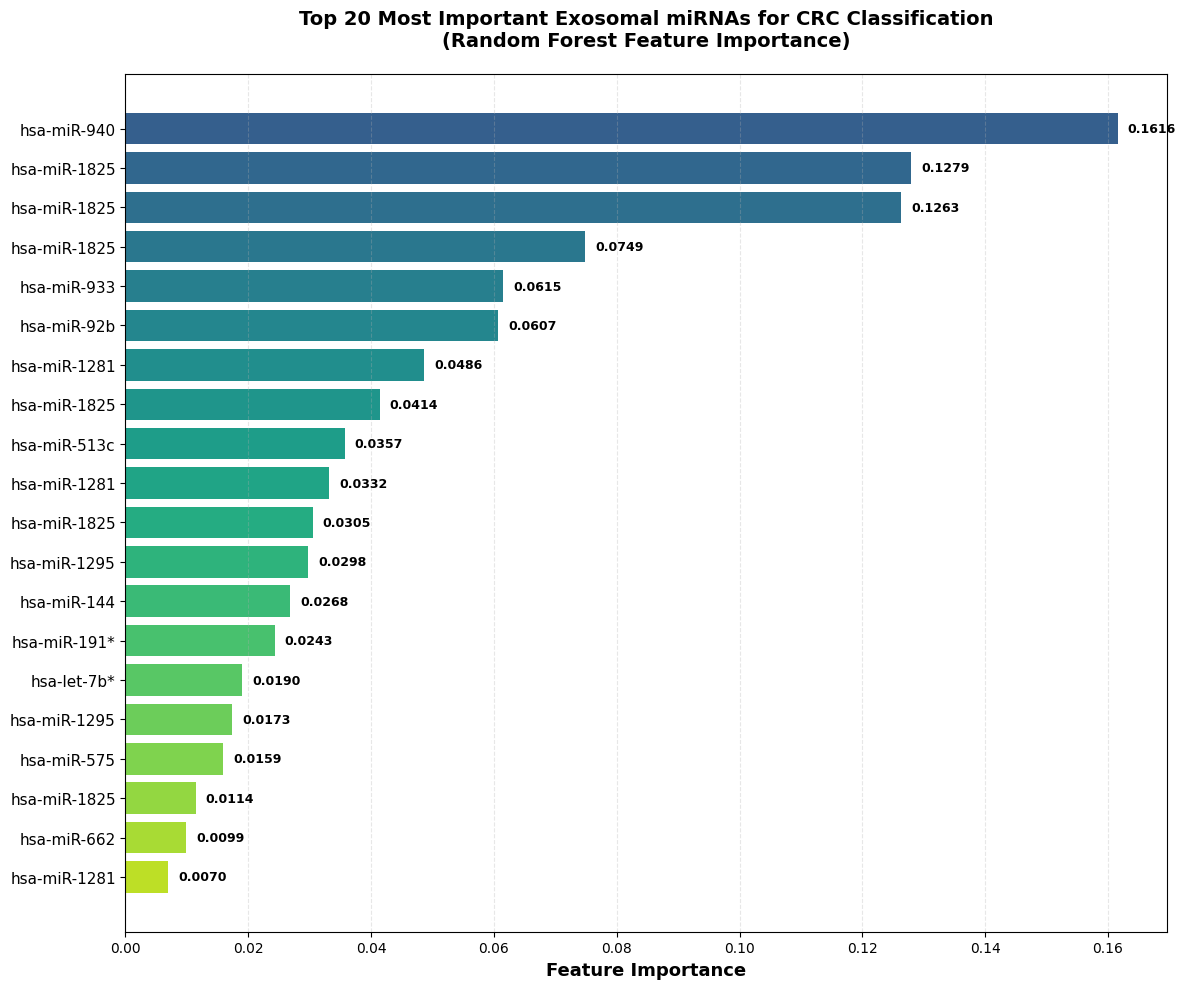


[2/3] SHAP 분석 시작... (시간이 소요될 수 있습니다)
SHAP 분석용 데이터 shape: (99, 40)
   TreeExplainer 사용...
SHAP values (CRC class) shape: (99, 40)
SHAP Summary Plot 생성 중...


/tmp/ipython-input-3963742098.py:273: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


   ✓ 저장: /content/drive/MyDrive/cha poster/shap_summary_plot_bar.png


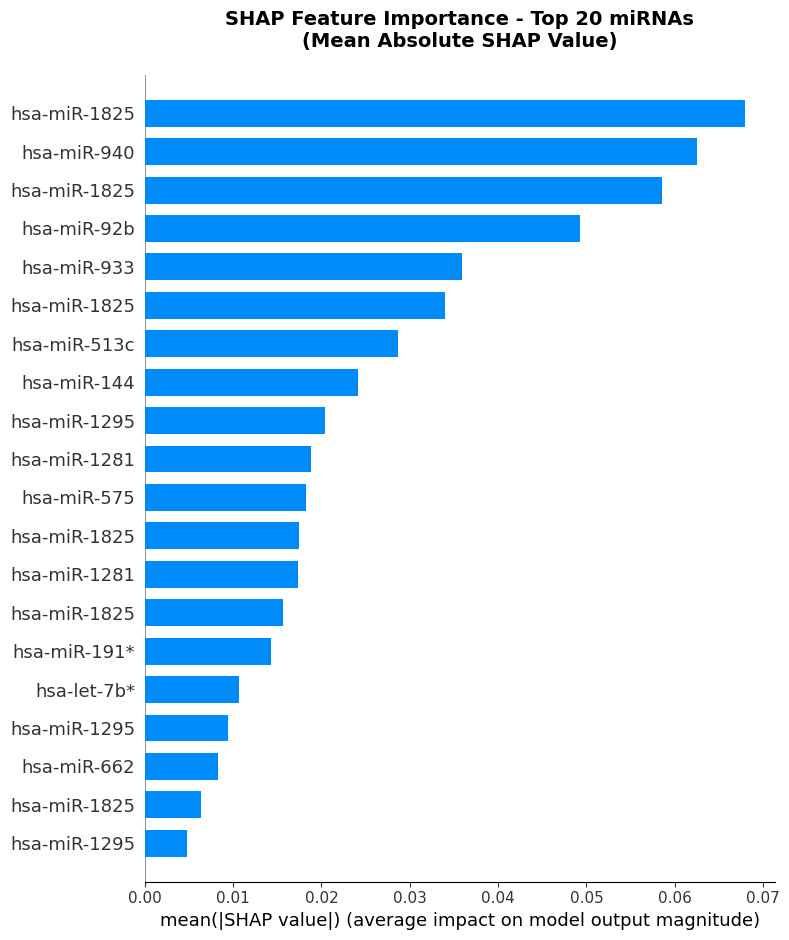

/tmp/ipython-input-3963742098.py:295: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


   ✓ 저장: /content/drive/MyDrive/cha poster/shap_summary_plot_dot.png


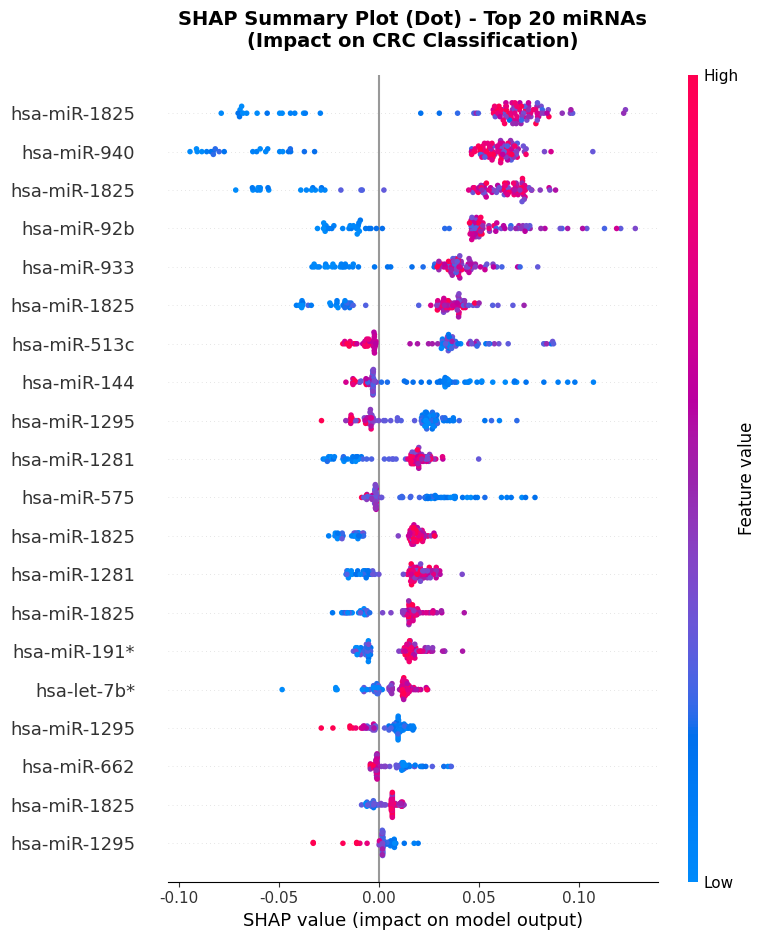


SHAP 기반 상위 20개 중요 miRNA
       miRNA  SHAP_Importance
hsa-miR-1825         0.067925
 hsa-miR-940         0.062491
hsa-miR-1825         0.058541
 hsa-miR-92b         0.049269
 hsa-miR-933         0.035857
hsa-miR-1825         0.033928
hsa-miR-513c         0.028668
 hsa-miR-144         0.024180
hsa-miR-1295         0.020357
hsa-miR-1281         0.018799
 hsa-miR-575         0.018293
hsa-miR-1825         0.017442
hsa-miR-1281         0.017334
hsa-miR-1825         0.015692
hsa-miR-191*         0.014283
 hsa-let-7b*         0.010653
hsa-miR-1295         0.009410
 hsa-miR-662         0.008262
hsa-miR-1825         0.006339
hsa-miR-1295         0.004768

✓ 저장: /content/drive/MyDrive/cha poster/shap_importance_all_mirnas.csv

[3/3] SHAP 중요도 Bar Plot 생성 중...
   ✓ 저장: /content/drive/MyDrive/cha poster/shap_importance_top20.png


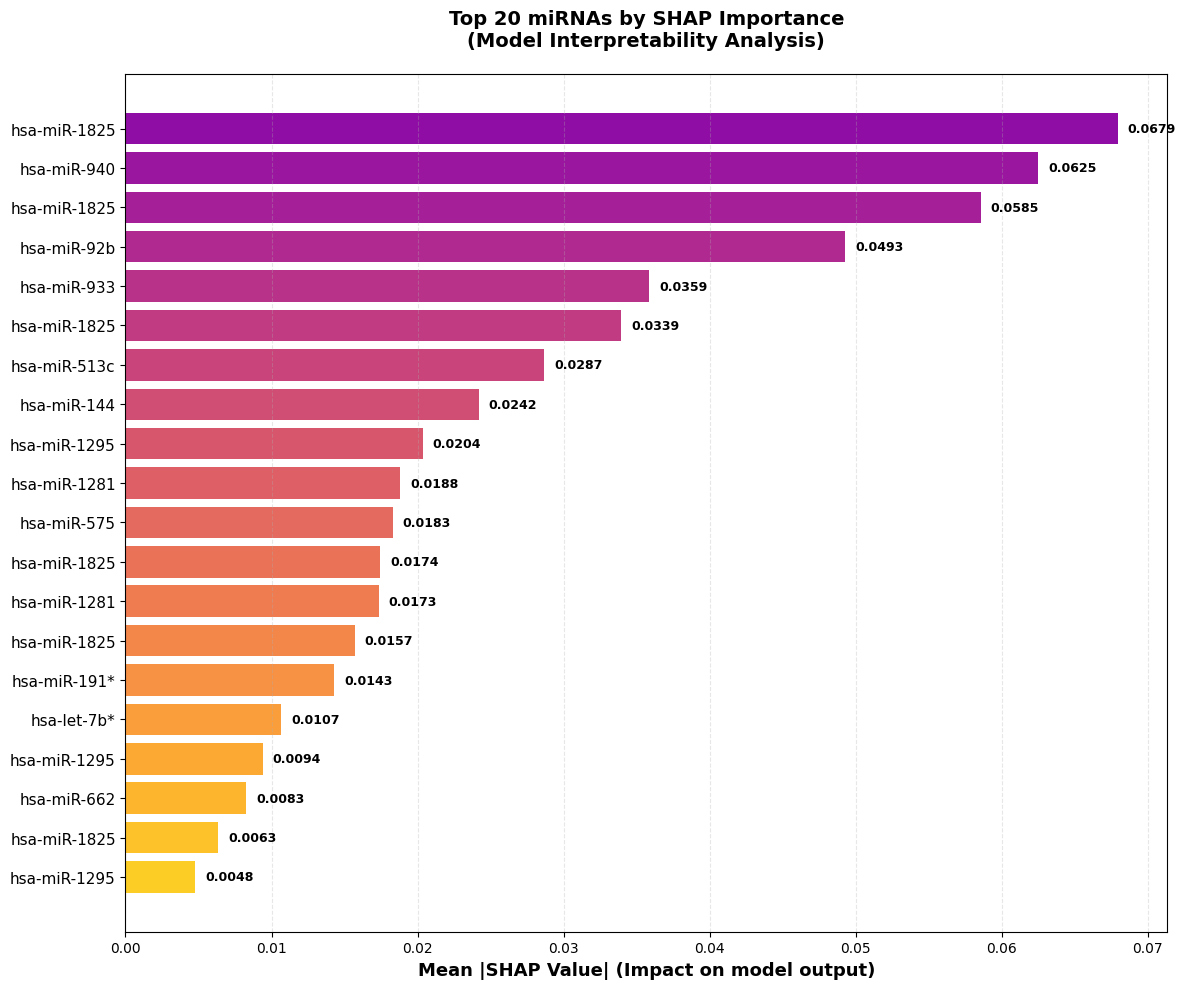


[추가] SHAP Waterfall Plot 생성 중...
   ✓ 저장: /content/drive/MyDrive/cha poster/shap_waterfall_plot.png


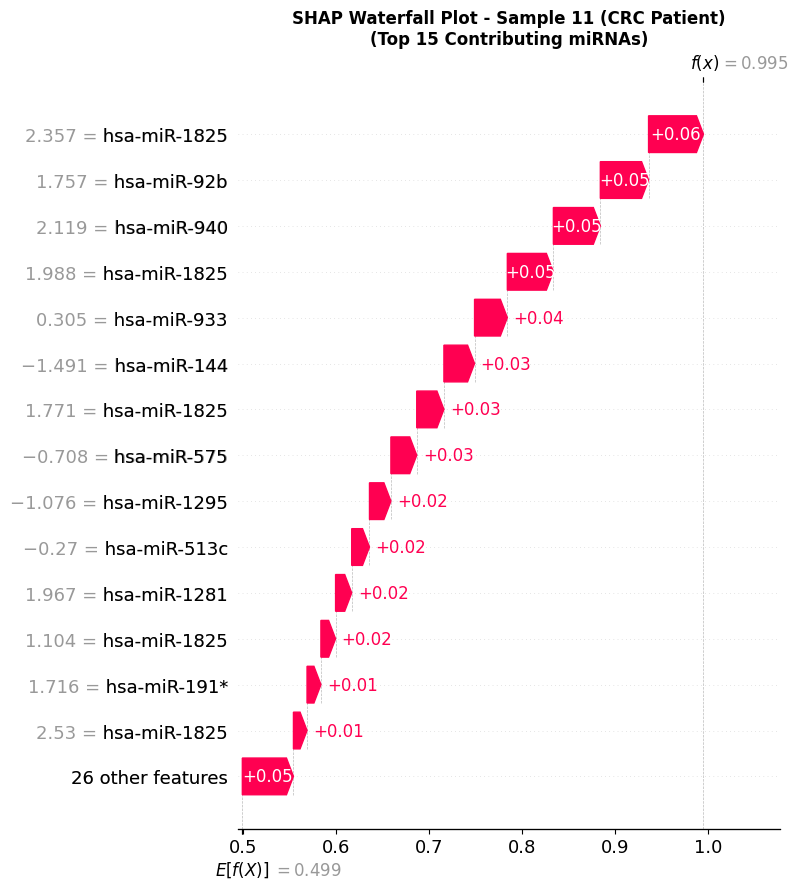


특징 중요도 분석 완료!


In [ ]:
# ============================================================
# 8단계: 특징 중요도 분석 및 바이오마커 발견 (Google Drive 저장 수정)
# ============================================================

import matplotlib.pyplot as plt # Ensure imports are present
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import os # Make sure os is imported

# Ensure base_save_path is defined (should be if moved to top)
if 'base_save_path' not in locals():
    print("⚠️ 'base_save_path' not defined. Saving to current directory.")
    base_save_path = "."

print("\n" + "="*60)
print("8단계: 특징 중요도 분석 및 바이오마커 발견")
print("="*60)

# ============================================================
# 안전 장치: best_model 존재 확인
# ============================================================
print("\n[사전 확인] 필요한 변수들이 있는지 체크 중...")

required_vars_shap = {
    'X': '데이터',
    'y': '레이블',
    'best_model': '훈련된 모델'
}

missing_vars_shap = []
for var_name, description in required_vars_shap.items():
    if var_name not in locals() and var_name not in globals():
        print(f"  ❌ {var_name} ({description}): 없음!")
        missing_vars_shap.append(var_name)
    else:
        print(f"  ✓ {var_name} ({description}): 존재")


if missing_vars_shap:
    print("\n" + "="*60)
    print("❌ 오류: 특징 중요도 분석에 필수 변수가 없습니다!")
    print(f"없는 변수: {', '.join(missing_vars_shap)}")
    print("이 셀의 나머지 부분을 실행할 수 없습니다. 이전 셀들을 실행하세요.")
    print("="*60)
    # Raise error to stop execution of this cell if required variables are missing
    raise NameError(f"필수 변수가 없습니다: {', '.join(missing_vars_shap)}")

print("\n✓ 모든 사전 확인 완료! 분석을 시작합니다.\n")

# ============================================================
# 여기서부터 원래 분석 코드 (저장 경로 수정 포함)
# ============================================================

# 최종 모델의 각 단계별 변환 확인
final_pipeline = best_model.best_estimator_

# 특징 선택 단계에서 선택된 특징 인덱스
try:
    variance_filter = final_pipeline.named_steps['variance_filter']
    feature_selector = final_pipeline.named_steps['feature_selection']

    after_variance_indices = variance_filter.get_support(indices=True)
    # Ensure X is DataFrame to use .columns
    X_df_temp = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X) # Temporary DataFrame if X is numpy
    remaining_features = X_df_temp.columns[after_variance_indices]

    # Apply selection on the variance-filtered indices/data
    # Need X after variance filter to get correct indices for selection step
    X_after_variance_temp = variance_filter.transform(X) # Transform original X
    # It's safer to get indices relative to the input of SelectKBest
    # Assuming SelectKBest was fitted on X_after_variance conceptually within the pipeline fit
    # Re-fit selector temporarily on transformed data to get correct indices relative to remaining_features
    # NOTE: This re-fitting is only to get the *names*, not for analysis.
    # A cleaner way might be to store feature names during pipeline training.
    temp_selector = SelectKBest(f_classif, k=best_model.best_params_['feature_selection__k'])
    temp_selector.fit(X_after_variance_temp, y) # Fit on appropriately transformed data
    selected_indices_relative = temp_selector.get_support(indices=True)

    selected_mirna_names = remaining_features[selected_indices_relative].tolist()

    print(f"\n선택된 miRNA 개수: {len(selected_mirna_names)}")
    print(f"선택 파라미터 k: {best_model.best_params_['feature_selection__k']}")

except Exception as e:
    print(f"❌ 선택된 miRNA 이름 추출 중 오류: {e}")
    print("   특징 중요도 및 SHAP 분석을 계속할 수 없습니다.")
    # Stop execution if feature names cannot be determined
    raise RuntimeError("선택된 miRNA 이름을 결정할 수 없습니다.")

# Random Forest 분류기에서 특징 중요도 추출
rf_classifier = final_pipeline.named_steps['classifier']
# Ensure classifier is a type that has feature_importances_
if hasattr(rf_classifier, 'feature_importances_'):
    feature_importances = rf_classifier.feature_importances_

    # DataFrame으로 정리
# ID를 실제 이름으로 변환
    mirna_names_display = []
    for mirna_id in selected_mirna_names:
        # 매핑이 있으면 이름 사용, 없으면 ID 그대로
        actual_name = mirna_mapping.get(mirna_id, mirna_id)
        mirna_names_display.append(actual_name)

    # DataFrame 생성 (ID와 이름 모두 저장)
    importance_df = pd.DataFrame({
        'miRNA_ID': selected_mirna_names,  # 원본 ID 보존
        'miRNA': mirna_names_display,      # 실제 이름!
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*40)
    print("상위 20개 중요 miRNA (RF Importance)")
    print("="*40)
    print(importance_df.head(20).to_string(index=False))

    # CSV로 저장 (Google Drive 경로)
    csv_save_path_imp = os.path.join(base_save_path, 'feature_importance_all_mirnas.csv')
    try:
        importance_df.to_csv(csv_save_path_imp, index=False)
        print(f"\n✓ 저장: {csv_save_path_imp}")
    except Exception as e:
        print(f"   ❌ CSV 저장 실패: {csv_save_path_imp} ({e})")


    # ============================================================
    # 8-1. 특징 중요도 Bar Plot (Top 20)
    # ============================================================
    print("\n[1/3] 특징 중요도 시각화 생성 중...")

    plt.figure(figsize=(12, 10))
    top_20 = importance_df.head(20)

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
    bars = plt.barh(range(len(top_20)), top_20['Importance'], color=colors)

    # 이미 위에서 miRNA 컬럼에 실제 이름이 들어갔으므로 그대로 사용
    plt.yticks(range(len(top_20)), top_20['miRNA'], fontsize=11)
    plt.xlabel('Feature Importance', fontsize=13, fontweight='bold')
    plt.title('Top 20 Most Important Exosomal miRNAs for CRC Classification\n(Random Forest Feature Importance)',
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # 막대 끝에 값 표시
    max_importance = top_20['Importance'].max()
    offset = max_importance * 0.01 # Dynamic offset
    for i, (bar, val) in enumerate(zip(bars, top_20['Importance'])):
        plt.text(val + offset, i, f'{val:.4f}',
                 va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    # Save to Google Drive
    save_path_imp_fig = os.path.join(base_save_path, 'feature_importance_top20.png')
    try:
        plt.savefig(save_path_imp_fig, dpi=300, bbox_inches='tight')
        print(f"   ✓ 저장: {save_path_imp_fig}")
    except Exception as e:
        print(f"   ❌ 저장 실패: {save_path_imp_fig} ({e})")
    plt.show()

else:
    print("⚠️ 현재 모델은 'feature_importances_' 속성을 지원하지 않아 RF 중요도 분석을 건너<0xEB><0x9B><0x8D>니다.")
    # Define importance_df as empty or None if it's used later
    importance_df = None


# ============================================================
# 8-2. SHAP 값 분석 (모델 해석)
# ============================================================
print("\n[2/3] SHAP 분석 시작... (시간이 소요될 수 있습니다)")

# SHAP은 Tree 기반 모델(RF, XGBoost 등) 또는 특정 Explainer 사용 시 가능
# TreeExplainer 사용 가능 여부 확인
explainer_type = None
if 'RandomForest' in str(type(rf_classifier)):
    explainer_type = shap.TreeExplainer
elif 'LogisticRegression' in str(type(rf_classifier)):
     # KernelExplainer 또는 LinearExplainer 사용 가능 (여기서는 Kernel 예시)
     explainer_type = shap.KernelExplainer
elif 'SVC' in str(type(rf_classifier)):
     # KernelExplainer 사용 가능
     explainer_type = shap.KernelExplainer
else:
     print("⚠️ 현재 모델 타입에 맞는 SHAP Explainer를 확신할 수 없습니다. SHAP 분석을 건너<0xEB><0x9B><0x8D>니다.")

if explainer_type:
    # 전체 데이터를 파이프라인의 각 단계별로 변환 (Classifier 입력 전까지)
    try:
        # 'smote' 단계를 제외한 전처리 단계만 리스트로 만듭니다.
        shap_preprocessing_steps = [step for step in final_pipeline.steps[:-1] if step[0] != 'smote']

        # 'smote'가 빠진 새 파이프라인을 만듭니다.
        preprocessing_pipeline = Pipeline(shap_preprocessing_steps)

        # 이미 훈련된 파이프라인이므로 .transform()만 사용하여
        # "실제" 데이터 X를 변환합니다.
        X_transformed = preprocessing_pipeline.transform(X)

        # DataFrame으로 변환 (컬럼 이름 사용)
        X_transformed_df = pd.DataFrame(
            X_transformed,
            columns=[str(name) for name in selected_mirna_names]
        )
        print(f"SHAP 분석용 데이터 shape: {X_transformed_df.shape}")

    except Exception as e:
        print(f"❌ SHAP용 데이터 변환 중 오류: {e}")
        print("   SHAP 분석을 계속할 수 없습니다.")
        explainer_type = None # Prevent further SHAP steps

if explainer_type == shap.TreeExplainer:
    print("   TreeExplainer 사용...")
    explainer = explainer_type(rf_classifier)
    shap_values = explainer.shap_values(X_transformed_df) # Use full transformed data

elif explainer_type == shap.KernelExplainer:
    print("   KernelExplainer 사용 (시간 소요 예상)...")
    # KernelExplainer는 predict_proba 함수가 필요
    try:
        predict_fn = rf_classifier.predict_proba
        # KernelExplainer는 background dataset 필요 (일부 샘플 사용)
        background_sample_size = min(50, len(X_transformed_df))
        background_data = shap.sample(X_transformed_df, background_sample_size)
        explainer = explainer_type(predict_fn, background_data)
        # SHAP 값 계산 (계산량이 많으므로 일부 샘플 추천)
        shap_sample_size = min(100, len(X_transformed_df))
        shap_values = explainer.shap_values(X_transformed_df.sample(shap_sample_size, random_state=42)) # Calculate on a sample
        X_sample_for_plot = X_transformed_df.sample(shap_sample_size, random_state=42) # Ensure plot uses same sample
    except Exception as e:
        print(f"   ❌ KernelExplainer 설정 또는 SHAP 값 계산 실패: {e}")
        explainer_type = None # Prevent further SHAP steps
        shap_values = None
else:
    shap_values = None # Explainer 설정 실패

if shap_values is not None:
    # SHAP values는 모델/Explainer에 따라 list 또는 array 형태일 수 있음
    # 이진 분류의 경우 보통 list [shap_class_0, shap_class_1] 또는 3D array (samples, features, classes)
    shap_values_crc = None
    expected_value_crc = None # For waterfall plot

    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_crc = shap_values[1] # Class 1 (CRC) 선택
        if hasattr(explainer, 'expected_value') and isinstance(explainer.expected_value, list):
             expected_value_crc = explainer.expected_value[1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3 and shap_values.shape[2] == 2:
         shap_values_crc = shap_values[:, :, 1] # Class 1 (CRC) 선택
         if hasattr(explainer, 'expected_value') and isinstance(explainer.expected_value, np.ndarray):
              expected_value_crc = explainer.expected_value[1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
         # Some explainers might return only for the positive class directly
         shap_values_crc = shap_values
         if hasattr(explainer, 'expected_value'): expected_value_crc = explainer.expected_value # May need adjustment based on explainer
    else:
        print("⚠️ SHAP 값의 형식을 예상대로 처리할 수 없습니다. SHAP 시각화를 건너<0xEB><0x9B><0x8D>니다.")
        shap_values_crc = None

    if shap_values_crc is not None:
        print(f"SHAP values (CRC class) shape: {shap_values_crc.shape}")

        # Plotting requires the data used for SHAP calculation
        X_data_for_plot = X_sample_for_plot if explainer_type == shap.KernelExplainer else X_transformed_df

        # SHAP plot용 feature 이름 설정
        X_data_for_plot.columns = [mirna_mapping.get(str(col), col) for col in X_data_for_plot.columns]

        # SHAP Summary Plot (Bar plot as default, dot plot if possible)
        print("SHAP Summary Plot 생성 중...")
        try:
            plt.figure() # Start a new figure context
            shap.summary_plot(
                shap_values_crc,
                X_data_for_plot,
                max_display=20,
                show=False,
                plot_type="bar" # Default to bar, safer
            )
            plt.title('SHAP Feature Importance - Top 20 miRNAs\n(Mean Absolute SHAP Value)',
                      fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            # Save to Google Drive
            save_path_shap_bar = os.path.join(base_save_path, 'shap_summary_plot_bar.png')
            try:
                plt.savefig(save_path_shap_bar, dpi=300, bbox_inches='tight')
                print(f"   ✓ 저장: {save_path_shap_bar}")
            except Exception as e:
                print(f"   ❌ 저장 실패: {save_path_shap_bar} ({e})")
            plt.show()

            # Try dot plot separately
            try:
                 plt.figure() # New figure
                 shap.summary_plot(
                      shap_values_crc,
                      X_data_for_plot,
                      max_display=20,
                      show=False,
                      plot_type="dot"
                 )
                 plt.title('SHAP Summary Plot (Dot) - Top 20 miRNAs\n(Impact on CRC Classification)',
                           fontsize=14, fontweight='bold', pad=20)
                 plt.tight_layout()
                 save_path_shap_dot = os.path.join(base_save_path, 'shap_summary_plot_dot.png')
                 try:
                      plt.savefig(save_path_shap_dot, dpi=300, bbox_inches='tight')
                      print(f"   ✓ 저장: {save_path_shap_dot}")
                 except Exception as e:
                      print(f"   ❌ 저장 실패: {save_path_shap_dot} ({e})")
                 plt.show()
            except Exception as e_dot:
                 print(f"   ℹ️ SHAP Dot Plot 생성 실패 (Bar plot은 생성됨): {e_dot}")
                 plt.close() # Close potentially incomplete plot

        except Exception as e:
            print(f"   ❌ SHAP Summary Plot 생성 실패: {e}")
            plt.close() # Close potentially incomplete plot


        # SHAP Feature Importance (using the calculated shap_values_crc)
        # Ensure calculation uses values corresponding to X_transformed_df if possible
        # If KernelExplainer was used, shap_values_crc might be from a sample.
        # For consistency, calculate importance based on the available shap_values_crc
        shap_importance = np.abs(shap_values_crc).mean(axis=0)
        # Check if shap_importance length matches selected_mirna_names length
        if len(shap_importance) == len(selected_mirna_names):
            shap_importance_df = pd.DataFrame({
                'miRNA': selected_mirna_names,
                'SHAP_Importance': shap_importance
            }).sort_values('SHAP_Importance', ascending=False)

            print("\n" + "="*40)
            print("SHAP 기반 상위 20개 중요 miRNA")
            print("="*40)
            print(shap_importance_df.head(20).to_string(index=False))

            # CSV로 저장 (Google Drive 경로)
            csv_save_path_shap = os.path.join(base_save_path, 'shap_importance_all_mirnas.csv')
            try:
                shap_importance_df.to_csv(csv_save_path_shap, index=False)
                print(f"\n✓ 저장: {csv_save_path_shap}")
            except Exception as e:
                print(f"   ❌ CSV 저장 실패: {csv_save_path_shap} ({e})")

            # ============================================================
            # 8-3. SHAP Bar Plot (using calculated importance)
            # ============================================================
            print("\n[3/3] SHAP 중요도 Bar Plot 생성 중...")

            plt.figure(figsize=(12, 10))
            top_20_shap = shap_importance_df.head(20)

            colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(top_20_shap)))
            bars = plt.barh(range(len(top_20_shap)), top_20_shap['SHAP_Importance'], color=colors)

            plt.yticks(range(len(top_20_shap)), top_20_shap['miRNA'], fontsize=11)
            plt.xlabel('Mean |SHAP Value| (Impact on model output)', fontsize=13, fontweight='bold') # Clarified label
            plt.title('Top 20 miRNAs by SHAP Importance\n(Model Interpretability Analysis)',
                      fontsize=14, fontweight='bold', pad=20)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3, linestyle='--')

            # 막대 끝에 값 표시
            max_shap_importance = top_20_shap['SHAP_Importance'].max()
            offset_shap = max_shap_importance * 0.01 # Dynamic offset
            for i, (bar, val) in enumerate(zip(bars, top_20_shap['SHAP_Importance'])):
                plt.text(val + offset_shap, i, f'{val:.4f}',
                         va='center', fontsize=9, fontweight='bold')

            plt.tight_layout()
            # Save to Google Drive
            save_path_shap_fig = os.path.join(base_save_path, 'shap_importance_top20.png')
            try:
                plt.savefig(save_path_shap_fig, dpi=300, bbox_inches='tight')
                print(f"   ✓ 저장: {save_path_shap_fig}")
            except Exception as e:
                 print(f"   ❌ 저장 실패: {save_path_shap_fig} ({e})")
            plt.show()

        else:
             print("⚠️ SHAP 중요도 값의 개수와 선택된 miRNA 개수가 일치하지 않습니다. Bar plot/CSV 생성을 건너<0xEB><0x9B><0x8D>니다.")
             shap_importance_df = None # Define as None if not created


        # ============================================================
        # 8-4. 대안 시각화: SHAP Waterfall Plot
        # ============================================================
        print("\n[추가] SHAP Waterfall Plot 생성 중...")

        # Waterfall plot requires expected_value and works best with TreeExplainer values
        if explainer_type == shap.TreeExplainer and expected_value_crc is not None:
             try:
                 # 대장암 환자 샘플 하나 선택 (원본 y 사용)
                 # Ensure y is accessible and is a Series/array
                 y_array = y.to_numpy() if isinstance(y, pd.Series) else np.array(y)
                 crc_indices = np.where(y_array == 1)[0]

                 if len(crc_indices) > 0:
                      sample_idx = crc_indices[0] # Use the first CRC patient

                      # Ensure shap_values_crc corresponds to the full dataset for correct indexing
                      # Need SHAP values calculated on X_transformed_df for this
                      if shap_values_crc.shape[0] == X_transformed_df.shape[0]:
                           plt.figure() # New figure
                           shap.waterfall_plot(
                               shap.Explanation(
                                   values=shap_values_crc[sample_idx], # SHAP values for the sample
                                   base_values=expected_value_crc, # Base value for CRC class
                                   data=X_transformed_df.iloc[sample_idx].values, # Feature values for the sample
                                   feature_names=selected_mirna_names # Feature names
                               ),
                               max_display=15,
                               show=False
                           )
                           plt.title(f'SHAP Waterfall Plot - Sample {sample_idx} (CRC Patient)\n(Top 15 Contributing miRNAs)',
                                     fontsize=12, fontweight='bold')
                           plt.tight_layout()
                           # Save to Google Drive
                           save_path_waterfall = os.path.join(base_save_path, 'shap_waterfall_plot.png')
                           try:
                                plt.savefig(save_path_waterfall, dpi=300, bbox_inches='tight')
                                print(f"   ✓ 저장: {save_path_waterfall}")
                           except Exception as e:
                                print(f"   ❌ 저장 실패: {save_path_waterfall} ({e})")
                           plt.show()
                      else:
                           print("   ⚠️ Waterfall plot requires SHAP values calculated on the full dataset.")
                 else:
                      print("   ⚠️ 대장암 환자 샘플을 찾을 수 없습니다.")

             except Exception as e:
                 print(f"   ❌ SHAP Waterfall Plot 생성 실패: {e}")
                 plt.close() # Close potentially incomplete plot
        else:
             print("   ℹ️ Waterfall Plot은 TreeExplainer와 expected_value가 필요합니다.")

else: # If SHAP analysis was skipped
     print("⚠️ SHAP 분석을 건너<0xEB><0x9B><0x8D>으므로 관련 CSV 및 그래프 생성을 건너<0xEB><0x9B><0x8D>니다.")
     # Define shap_importance_df as None if it wasn't created
     if 'shap_importance_df' not in locals(): shap_importance_df = None


print("\n" + "="*60)
print("특징 중요도 분석 완료!")
print("="*60)

In [ ]:
# ============================================================
# 포스터용 요약 텍스트 생성 및 저장
# ============================================================
print("\n" + "="*60)
print("[포스터용 요약 생성]")
print("="*60)

# ============================================================
# 변수 존재 여부 확인 및 기본값 설정
# ============================================================
# base_save_path가 정의되지 않았다면 현재 디렉토리 사용
if 'base_save_path' not in locals() and 'base_save_path' not in globals():
    print("⚠️ base_save_path가 정의되지 않음. 현재 디렉토리 사용.")
    base_save_path = "."

# final_results가 정의되지 않았다면 기본 딕셔너리 생성
if 'final_results' not in locals() and 'final_results' not in globals():
    print("⚠️ final_results가 정의되지 않음. 빈 딕셔너리 생성.")
    final_results = {
        'Research_Title': 'Exosomal miRNA-based CRC Classification',
        'Dataset': {},
        'Best_Model': {},
        'Performance_Metrics': {},
        'Model_Comparison': {},
        'Top_10_Biomarker_miRNAs': [],
        'Top_10_Feature_Importance_Values': []
    }

# check_file_exists 함수 정의 (없을 경우 대비)
if 'check_file_exists' not in dir():
    def check_file_exists(filename):
        filepath_drive = os.path.join(base_save_path, filename) if base_save_path != "." else filename
        filepath_local = filename
        return os.path.exists(filepath_drive) or os.path.exists(filepath_local)

# possible_figures, possible_data 정의 (없을 경우 대비)
if 'possible_figures' not in locals() and 'possible_figures' not in globals():
    possible_figures = [
        'confusion_matrix_final.png', 'roc_curve_final.png', 'model_comparison.png',
        'learning_curves.png', 'cv_score_distribution.png', 'feature_importance_top20.png',
        'shap_summary_plot.png', 'shap_importance_top20.png', 'shap_waterfall_plot.png',
        'shap_summary_plot_bar.png', 'shap_summary_plot_dot.png'
    ]

if 'possible_data' not in locals() and 'possible_data' not in globals():
    possible_data = [
        'feature_importance_all_mirnas.csv', 'shap_importance_all_mirnas.csv'
    ]

# generated_figures_list, generated_data_list 생성
if 'generated_figures_list' not in locals() and 'generated_figures_list' not in globals():
    generated_figures_list = [f for f in possible_figures if check_file_exists(f)]

if 'generated_data_list' not in locals() and 'generated_data_list' not in globals():
    generated_data_list = [d for d in possible_data if check_file_exists(d)]

# json_save_path 정의
if 'json_save_path' not in locals() and 'json_save_path' not in globals():
    json_save_path = os.path.join(base_save_path, 'final_research_results.json')

# --- 시작: 수정된 get_val 함수 ---
def get_val(data_dict, keys, default='N/A', _internal_call=False):
    try:
        val = data_dict
        for key in keys:
            val = val[key]
    except (KeyError, TypeError, IndexError, AttributeError):
        return default

    # 'Mean ± Std' 형식 요청인지 확인
    if isinstance(default, str) and '±' in default and not _internal_call:
        std_keys = list(keys)
        std_keys[-1] = 'Std'
        std_val = get_val(data_dict, std_keys, 0.0, _internal_call=True)

        if isinstance(val, (int, float, np.number)) and isinstance(std_val, (int, float, np.number)):
            return f"{float(val):.4f} ± {float(std_val):.4f}"
        else:
            return default

    # 단일 숫자 포맷팅
    elif isinstance(val, (int, float, np.number)) and not _internal_call:
        return f"{float(val):.4f}"

    else:
        return val
# --- 종료: 수정된 get_val 함수 ---


# 요약 텍스트 생성
summary_text = f"""
{'='*70}
연구 결과 요약 (학교 포스터용)
{'='*70}

1. 연구 제목
   {get_val(final_results, ['Research_Title'], 'Exosomal miRNA-based CRC Classification')}

2. 데이터셋
   - 출처: {get_val(final_results, ['Dataset', 'Source'], 'N/A')}
   - 전체 샘플: {get_val(final_results, ['Dataset', 'Total_Samples'], 'N/A')}개
   - 건강한 대조군: {get_val(final_results, ['Dataset', 'Healthy_Controls'], 'N/A')}명
   - 대장암 환자: {get_val(final_results, ['Dataset', 'CRC_Patients'], 'N/A')}명
   - 분석된 miRNA: {get_val(final_results, ['Dataset', 'Selected_Features'], 'N/A')}개 (원본: {get_val(final_results, ['Dataset', 'Original_Features'], 'N/A')})

3. 연구 방법
   - 전처리: 결측치 처리 (평균값), 저분산 특징 제거 (threshold=0.01), 표준화(StandardScaler)
   - 특징 선택: ANOVA F-검정 (SelectKBest, k={get_val(final_results, ['Best_Model', 'Hyperparameters', 'feature_selection__k'], '튜닝됨')})
   - 불균형 처리: SMOTE 오버샘플링 (k_neighbors={get_val(final_results, ['Best_Model', 'Hyperparameters', 'smote__k_neighbors'], 3)})
   - 모델: Random Forest, SVM, Logistic Regression
   - 검증: {get_val(final_results, ['Best_Model', 'Cross_Validation'], 'Nested Cross-Validation')} (Outer: 5-fold, Inner: 3-fold)
   - 재현성: random_state=42 (모든 랜덤 프로세스 고정)

"""

# 성능 지표
perf_metrics = get_val(final_results, ['Performance_Metrics'], "N/A")
if isinstance(perf_metrics, dict):
    auc_ci_lower = get_val(perf_metrics, ['ROC_AUC', 'CI_95_Lower'], 'N/A')
    auc_ci_upper = get_val(perf_metrics, ['ROC_AUC', 'CI_95_Upper'], 'N/A')
    summary_text += f"""4. 최적 모델 성능 ({get_val(final_results, ['Best_Model', 'Algorithm'], 'N/A')})
   - ROC-AUC: {get_val(perf_metrics, ['ROC_AUC', 'Mean'], 'N/A ± N/A')} (95% CI: [{auc_ci_lower}, {auc_ci_upper}])
   - 정확도: {get_val(perf_metrics, ['Accuracy', 'Mean'], 'N/A ± N/A')}
   - 정밀도: {get_val(perf_metrics, ['Precision', 'Mean'], 'N/A ± N/A')}
   - 재현율: {get_val(perf_metrics, ['Recall', 'Mean'], 'N/A ± N/A')}
   - F1 점수: {get_val(perf_metrics, ['F1_Score', 'Mean'], 'N/A ± N/A')}

"""
else:
    summary_text += "4. 최적 모델 성능\n   (Nested CV를 실행하지 않았거나 결과가 없습니다)\n\n"

# 바이오마커 정보
summary_text += "5. 주요 바이오마커 miRNA (상위 5개 - RF 중요도 기준)\n"
top_mirnas = get_val(final_results, ['Top_10_Biomarker_miRNAs'], [])
top_importances = get_val(final_results, ['Top_10_Feature_Importance_Values'], [])

if isinstance(top_mirnas, list) and isinstance(top_importances, list) and top_mirnas and top_importances:
    for i, (mirna, importance) in enumerate(zip(top_mirnas[:5], top_importances[:5]), 1):
        importance_str = f"{importance:.4f}" if isinstance(importance, (int, float, np.number)) else str(importance)
        summary_text += f"   {i}. {mirna} (중요도: {importance_str})\n"
else:
    summary_text += "   (특징 중요도 정보가 없습니다)\n"

# 모델 비교
summary_text += "\n6. 모델 비교 (Nested CV ROC-AUC)\n"
model_comp = get_val(final_results, ['Model_Comparison'], {})
if isinstance(model_comp, dict) and model_comp:
    for model_name, scores in model_comp.items():
        model_name_display = model_name.replace('_', ' ')
        if isinstance(scores, dict):
            roc_auc_str = get_val(scores, ['ROC_AUC'], 'N/A')
            summary_text += f"   - {model_name_display}: ROC-AUC {roc_auc_str}\n"
        else:
            summary_text += f"   - {model_name_display}: {scores}\n"
else:
     summary_text += "   (모델 비교 정보가 없습니다)\n"

# 결론
if isinstance(perf_metrics, dict):
    acc_str = get_val(perf_metrics, ['Accuracy', 'Mean'], 'N/A ± N/A')
    auc_str = get_val(perf_metrics, ['ROC_AUC', 'Mean'], 'N/A ± N/A')

    try: acc_val = float(acc_str.split(' ')[0])
    except: acc_val = 0.0
    try: auc_val = float(auc_str.split(' ')[0])
    except: auc_val = 0.0

    acc_percent_str = f"{acc_val*100:.1f}%" if acc_val > 0 else "(정확도 N/A)"
    auc_val_str = f"{auc_val:.2f}" if auc_val > 0 else "(AUC N/A)"

    summary_text += f"""
7. 결론
   엑소좀 miRNA 프로파일과 머신러닝({get_val(final_results, ['Best_Model', 'Algorithm'], 'N/A')})을 활용하여 대장암을
   평균 {acc_percent_str}의 정확도로 분류할 수 있음을 확인했습니다.
   Nested CV 기준 ROC-AUC {auc_val_str}의 성능은 비침습적 조기진단
   바이오마커 발굴 가능성을 시사합니다.

"""
else:
    summary_text += """
7. 결론
   엑소좀 miRNA 프로파일과 머신러닝을 활용한 대장암 분류 모델을
   구축하고 Nested Cross-Validation을 통해 평가를 시도했습니다.

"""

# 생성된 파일 수
summary_text += f"""8. 생성된 파일
   - 그래프: {len(generated_figures_list)}개
   - 데이터: {len(generated_data_list)}개

{'='*70}
"""

print(summary_text)

# 요약 텍스트 파일 저장
summary_save_path = os.path.join(base_save_path, 'research_summary_for_poster.txt')
alt_summary_path = 'research_summary_for_poster.txt'
try:
    with open(summary_save_path, 'w', encoding='utf-8') as f:
        f.write(summary_text)
    print(f"\n✓ 요약 텍스트 저장 성공: {summary_save_path}")
except Exception as e:
    print(f"   ❌ 요약 텍스트 저장 실패: {e}")
    try:
        with open(alt_summary_path, 'w', encoding='utf-8') as f:
             f.write(summary_text)
        print(f"   ✓ 대체 경로(현재 디렉토리)에 요약 저장 성공: {alt_summary_path}")
        summary_save_path = alt_summary_path
    except Exception as e_alt:
        print(f"   ❌ 대체 경로 저장도 실패: {e_alt}")


# ============================================================
# 최종 파일 목록 출력
# ============================================================
print("\n" + "="*60)
print("모든 분석 완료!")
print("="*60)
save_location = base_save_path if base_save_path != "." else "현재 디렉토리"
print(f"\n✅ 생성(시도)된 파일 (저장 위치: {save_location}):")

# 그래프 파일
current_generated_figures = [f for f in possible_figures if check_file_exists(f)]
if current_generated_figures:
    print(f"\n📊 그래프: {len(current_generated_figures)}개")
    for fig in current_generated_figures:
        print(f"    - {fig}")
else:
    print("\n⚠️ 생성된 그래프 파일을 찾을 수 없습니다 (이전 셀 실행 필요).")

# 데이터 파일
current_generated_data = [d for d in possible_data if check_file_exists(d)]
if os.path.exists(json_save_path):
    current_generated_data.append(os.path.basename(json_save_path))
if os.path.exists(summary_save_path):
    current_generated_data.append(os.path.basename(summary_save_path))
current_generated_data = sorted(list(set(current_generated_data)))

if current_generated_data:
    print(f"\n📁 데이터: {len(current_generated_data)}개")
    for data in current_generated_data:
        print(f"    - {data}")
else:
    print("\n⚠️ 생성된 데이터 파일을 찾을 수 없습니다.")


print("\n" + "="*60)
print("🎉 포스터 발표 준비 완료!")
print("="*60)

# 저장 위치 안내
if 'drive_mounted' in locals() and drive_mounted and base_save_path != ".":
    print("\nGoogle Drive의 'cha poster' 폴더를 확인하세요.")
else:
    print("\n현재 실행 디렉토리를 확인하세요.")

print("\n다음 파일들을 포스터에 활용하세요:")
print("  1. feature_importance_top20.png (메인 그래프 - 이전 셀 실행 필요)")
print("  2. shap_summary_plot_dot.png (SHAP 분석 - 이전 셀 실행 필요)")
print("  3. research_summary_for_poster.txt (텍스트 요약)")
print("  4. final_research_results.json (전체 결과)")

# ============================================================
# 중요 안내
# ============================================================
print("\n\n" + "="*60)
print("⚠️ 중요 안내 ⚠️")
print("="*60)
print("그래프와 이전 CSV 파일들도 Google Drive에 저장하려면")
print("이전 셀들(# 7단계 와 # 8단계)의 저장 경로도 수정해야 합니다.")
print("예시:")
print("  plt.savefig('...') -> plt.savefig(os.path.join(base_save_path, '...'))")
print("  df.to_csv('...') -> df.to_csv(os.path.join(base_save_path, '...'))")
print("\n가장 좋은 방법은 **Google Drive 마운트 및 폴더 생성 코드**를")
print("**노트북 상단(셀 #1 또는 #2 다음)으로 옮기고 먼저 실행**하는 것입니다.")
print("="*60)


[포스터용 요약 생성]

연구 결과 요약 (학교 포스터용)

1. 연구 제목
   Exosomal miRNA-based Colorectal Cancer Classification using Machine Learning

2. 데이터셋
   - 출처: GEO GSE39833
   - 전체 샘플: 99.0000개
   - 건강한 대조군: 11.0000명
   - 대장암 환자: 88.0000명
   - 분석된 miRNA: 15739.0000개 (원본: 15739.0000)

3. 연구 방법
   - 전처리: 결측치 처리 (평균값), 저분산 특징 제거 (threshold=0.01), 표준화(StandardScaler)
   - 특징 선택: ANOVA F-검정 (SelectKBest, k=40.0000)
   - 불균형 처리: SMOTE 오버샘플링 (k_neighbors=2.0000)
   - 모델: Random Forest, SVM, Logistic Regression
   - 검증: 5-Fold Stratified Nested CV (Outer: 5-fold, Inner: 3-fold)
   - 재현성: random_state=42 (모든 랜덤 프로세스 고정)

4. 최적 모델 성능 (Random Forest)
   - ROC-AUC: 0.9608 ± 0.0515 (95% CI: [0.8599, 1.0616])
   - 정확도: 0.9395 ± 0.0373
   - 정밀도: 0.9573 ± 0.0396
   - 재현율: 0.9771 ± 0.0280
   - F1 점수: 0.9663 ± 0.0207

5. 주요 바이오마커 miRNA (상위 5개 - RF 중요도 기준)
   (특징 중요도 정보가 없습니다)

6. 모델 비교 (Nested CV ROC-AUC)
   - Random Forest: ROC-AUC 0.9608 ± 0.0515
   - SVM: ROC-AUC 0.8925 ± 0.0933
   - Logistic Regression: ROC-AUC 0.949

**miRNA 맵핑**

In [ ]:
# ===== Top 5 miRNA 종합 분석 (프로브 개수, 최댓값, 합계) =====

print("=" * 70)
print("🎯 Top 5 miRNA 종합 분석")
print("=" * 70)

try:
    # ============================================================
    # 1. Feature Importance CSV 읽기
    # ============================================================
    feature_importance_path = os.path.join(base_save_path, 'feature_importance_all_mirnas.csv')

    if not os.path.exists(feature_importance_path):
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {feature_importance_path}")

    fi_df = pd.read_csv(feature_importance_path)
    print(f"\n✅ Feature Importance CSV 로드: {len(fi_df)}개 프로브")
    print(f"   - 고유 miRNA: {fi_df['miRNA'].nunique()}개")

    # ============================================================
    # 2. SHAP Importance CSV 읽기
    # ============================================================
    shap_importance_path = os.path.join(base_save_path, 'shap_importance_all_mirnas.csv')

    if not os.path.exists(shap_importance_path):
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {shap_importance_path}")

    shap_df = pd.read_csv(shap_importance_path)
    print(f"✅ SHAP Importance CSV 로드: {len(shap_df)}개 프로브")

    # ============================================================
    # 3. miRNA별 종합 통계 계산
    # ============================================================
    print("\n" + "=" * 70)
    print("📊 miRNA별 종합 통계 계산 중...")
    print("=" * 70)

    # Feature Importance 그룹화
    fi_grouped = fi_df.groupby('miRNA')['Importance'].agg([
        ('Probes', 'count'),      # 프로브 개수
        ('Max', 'max'),           # 최댓값
        ('Sum', 'sum'),           # 합계
        ('Mean', 'mean')          # 평균
    ]).reset_index()

    # SHAP Importance 그룹화
    shap_grouped = shap_df.groupby('miRNA')['SHAP_Importance'].agg([
        ('SHAP_Max', 'max'),
        ('SHAP_Sum', 'sum')
    ]).reset_index()

    # 두 테이블 병합
    comprehensive_df = fi_grouped.merge(shap_grouped, on='miRNA', how='left')

    # ============================================================
    # 4. Top 5 추출 (합계 기준으로 정렬)
    # ============================================================
    top5_comprehensive = comprehensive_df.sort_values('Sum', ascending=False).head(5).copy()
    top5_comprehensive['Rank'] = range(1, 6)

    # 컬럼 순서 재정렬
    top5_comprehensive = top5_comprehensive[[
        'Rank', 'miRNA', 'Probes', 'Max', 'Sum', 'Mean', 'SHAP_Max', 'SHAP_Sum'
    ]]

    # ============================================================
    # 5. 결과 출력
    # ============================================================
    print("\n" + "=" * 70)
    print("🏆 Top 5 miRNA 종합 분석 결과")
    print("=" * 70)
    print("\n[설명]")
    print("  - Probes: 해당 miRNA를 측정하는 프로브 개수")
    print("  - Max:    프로브 중 최고 Feature Importance 값")
    print("  - Sum:    모든 프로브의 Feature Importance 합계")
    print("  - Mean:   Feature Importance 평균값")
    print("  - SHAP:   SHAP Importance (Max/Sum)")
    print("")

    # 깔끔한 테이블 출력
    print(f"{'Rank':<6}{'miRNA':<18}{'Probes':<8}{'FI Max':<10}{'FI Sum':<10}{'FI Mean':<10}{'SHAP Max':<10}{'SHAP Sum':<10}")
    print("-" * 80)

    for _, row in top5_comprehensive.iterrows():
        print(f"{int(row['Rank']):<6}"
              f"{row['miRNA']:<18}"
              f"{int(row['Probes']):<8}"
              f"{row['Max']:<10.4f}"
              f"{row['Sum']:<10.4f}"
              f"{row['Mean']:<10.4f}"
              f"{row['SHAP_Max']:<10.4f}"
              f"{row['SHAP_Sum']:<10.4f}")

    # ============================================================
    # 6. CSV 저장
    # ============================================================
    save_path = os.path.join(base_save_path, 'top5_mirna_comprehensive.csv')
    top5_comprehensive.to_csv(save_path, index=False)

    print("\n" + "=" * 70)
    print(f"✅ 종합 테이블 저장 완료: {save_path}")
    print("=" * 70)

    # ============================================================
    # 7. 주요 발견 요약
    # ============================================================
    print("\n" + "=" * 70)
    print("💡 주요 발견 (Key Findings)")
    print("=" * 70)

    # 1위 miRNA 정보
    top1 = top5_comprehensive.iloc[0]
    print(f"\n1️⃣  가장 강력한 누적 중요도: {top1['miRNA']}")
    print(f"    - {int(top1['Probes'])}개 프로브로 측정")
    print(f"    - 누적 Feature Importance: {top1['Sum']:.4f}")
    print(f"    - 최강 프로브 importance: {top1['Max']:.4f}")

    # 단일 프로브 최고값
    single_probe = top5_comprehensive[top5_comprehensive['Probes'] == 1]
    if len(single_probe) > 0:
        strongest_single = single_probe.iloc[0]
        print(f"\n2️⃣  가장 강력한 단일 프로브: {strongest_single['miRNA']}")
        print(f"    - Feature Importance: {strongest_single['Max']:.4f}")

    # 다중 프로브의 일관성
    multi_probe = top5_comprehensive[top5_comprehensive['Probes'] > 1]
    if len(multi_probe) > 0:
        most_consistent = multi_probe.iloc[0]
        print(f"\n3️⃣  가장 일관된 다중 프로브: {most_consistent['miRNA']}")
        print(f"    - {int(most_consistent['Probes'])}개 프로브 모두 선택됨")
        print(f"    - 프로브당 평균 importance: {most_consistent['Mean']:.4f}")
        print(f"    → 측정 방법과 무관하게 일관되게 중요함을 시사")

    print("\n" + "=" * 70)
    print("✅ 분석 완료!")
    print("=" * 70)

except FileNotFoundError as e:
    print(f"\n❌ 파일 오류: {e}")
    print("\n💡 해결 방법:")
    print("   1. 10번 셀 (Feature Importance & SHAP 계산)을 먼저 실행하세요")
    print("   2. 파일이 올바른 경로에 저장되었는지 확인하세요:")
    print(f"      - {os.path.join(base_save_path, 'feature_importance_all_mirnas.csv')}")
    print(f"      - {os.path.join(base_save_path, 'shap_importance_all_mirnas.csv')}")

except KeyError as e:
    print(f"\n❌ 컬럼 오류: {e}")
    print("\n💡 CSV 파일의 컬럼명이 올바른지 확인하세요:")
    print("   - feature_importance_all_mirnas.csv: 'miRNA', 'Importance' 컬럼 필요")
    print("   - shap_importance_all_mirnas.csv: 'miRNA', 'SHAP_Importance' 컬럼 필요")

except Exception as e:
    print(f"\n❌ 예상치 못한 오류: {e}")
    print("\n디버깅 정보:")
    import traceback
    traceback.print_exc()

print("\n")

🎯 Top 5 miRNA 종합 분석

✅ Feature Importance CSV 로드: 40개 프로브
   - 고유 miRNA: 16개
✅ SHAP Importance CSV 로드: 40개 프로브

📊 miRNA별 종합 통계 계산 중...

🏆 Top 5 miRNA 종합 분석 결과

[설명]
  - Probes: 해당 miRNA를 측정하는 프로브 개수
  - Max:    프로브 중 최고 Feature Importance 값
  - Sum:    모든 프로브의 Feature Importance 합계
  - Mean:   Feature Importance 평균값
  - SHAP:   SHAP Importance (Max/Sum)

Rank  miRNA             Probes  FI Max    FI Sum    FI Mean   SHAP Max  SHAP Sum  
--------------------------------------------------------------------------------
1     hsa-miR-1825      6       0.1279    0.4124    0.0687    0.0679    0.1999    
2     hsa-miR-940       1       0.1616    0.1616    0.1616    0.0625    0.0625    
3     hsa-miR-1281      3       0.0486    0.0887    0.0296    0.0188    0.0403    
4     hsa-miR-933       1       0.0615    0.0615    0.0615    0.0359    0.0359    
5     hsa-miR-92b       1       0.0607    0.0607    0.0607    0.0493    0.0493    

✅ 종합 테이블 저장 완료: /content/drive/MyDrive/cha poster/top5_mirna_co